In [1]:
import os
from pathlib import Path

# 方法 1：相對於 notebook 位置
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # 從 model/aapl 往上兩層
os.chdir(project_root)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np
import ta

In [3]:
df = pd.read_csv("data/2330_TW.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14)
df['k'] = stoch.stoch()
df['d'] = stoch.stoch_signal()
df

,Close,High,Low,Open,Volume,rsi,k,d
Date,,,,,,,,
2014-01-03,73.997704,74.358668,73.636739,74.358668,38599000,NaN,NaN,NaN
2014-01-06,73.997704,74.358668,73.636739,73.636739,23706000,NaN,NaN,NaN
2014-01-07,73.636726,74.358655,73.636726,73.997691,15836000,NaN,NaN,NaN
2014-01-08,75.080612,75.441577,73.997719,74.358683,30218000,NaN,NaN,NaN
2014-01-09,72.914787,74.358644,72.553823,73.997680,63998000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-25,564.011108,567.894145,563.040349,564.981868,9548143,58.299930,71.936110,67.926818
2023-12-26,568.864929,568.864929,564.981892,565.952651,16094308,62.416420,91.982151,79.954442
2023-12-27,574.689453,574.689453,568.864898,569.835657,33401336,66.668544,100.000000,87.972754


In [4]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume','rsi','k','d']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 5 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
X_train.shape[2]

(2439, 4)
torch.Size([1935, 5, 4])


4

In [5]:
import torch
import torch.nn as nn

class MLP_LSTM_Autoregressive(nn.Module):
    def __init__(self, input_size, mlp_hidden_size, lstm_hidden_size, output_size=None, lstm_layers=1, dropout=0.3, pred_len=5):
        super().__init__()
        self.pred_len = pred_len
        self.output_size = output_size if output_size else input_size

        # MLP 特徵轉換
        self.mlp = nn.Sequential(
            nn.Linear(input_size, mlp_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_size, mlp_hidden_size),
            nn.ReLU(),
        )

        # LSTM 編碼序列
        self.lstm = nn.LSTM(
            input_size=mlp_hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True
        )

        # 最終輸出層
        self.output_layer = nn.Linear(lstm_hidden_size, self.output_size)

        # 輸入投影（給 decoder）
        self.input_proj = nn.Linear(self.output_size, mlp_hidden_size)

    def forward(self, x):
        """
        x: [batch_size, seq_len, input_size]
        """
        batch_size, seq_len, _ = x.size()
        outputs = []

        # 將輸入丟進 MLP
        x_flat = x.view(-1, x.size(-1))  # [batch * seq_len, input_size]
        x_mlp = self.mlp(x_flat).view(batch_size, seq_len, -1)  # [batch, seq_len, mlp_hidden]

        # 初始 LSTM encoder
        lstm_out, (h, c) = self.lstm(x_mlp)

        # 用最後一個時間步作為 decoder 的起始輸入
        decoder_input = x[:, -1, :]  # [batch, input_size]
        
        for _ in range(self.pred_len):
            # 將 decoder_input 也丟進 MLP
            decoder_input_mlp = self.input_proj(decoder_input).unsqueeze(1)  # [batch, 1, mlp_hidden]
            decoder_output, (h, c) = self.lstm(decoder_input_mlp, (h, c))   # [batch, 1, lstm_hidden]
            step_output = self.output_layer(decoder_output.squeeze(1))      # [batch, output_size]
            outputs.append(step_output.unsqueeze(1))                        # 累積每一步預測

            # 自回歸地拿來當作下一步的輸入
            decoder_input = step_output

        return torch.cat(outputs, dim=1)  # [batch_size, pred_len, output_size]


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 1e-4

feature_size = 4  # 輸入特徵數
num_layers = 2
nhead = 4
hidden_dim = 128

model = MLP_LSTM_Autoregressive(
    input_size=feature_size,          # 每天的特徵數
    mlp_hidden_size=64,
    lstm_hidden_size=128,
    output_size=feature_size,         # 預測與輸入一樣的維度（自回歸）
    pred_len=5
).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [7]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "output/model/2330tw/mlp_lstm_5.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        # print(x_batch.shape)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        # print(outputs.shape)
        # print(y_batch.shape)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch).squeeze(-1)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < min_val_loss and epoch>50:
        min_val_loss = val_loss
        torch.save(model, best_model_path)  
        print(f"Model saved with val_loss: {val_loss:.4f}")
    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 0.0820, Val Loss: 0.2607
Epoch [2/100], Train Loss: 0.0895, Val Loss: 0.2429
Epoch [3/100], Train Loss: 0.0771, Val Loss: 0.1921
Epoch [4/100], Train Loss: 0.0646, Val Loss: 0.1105
Epoch [5/100], Train Loss: 0.0399, Val Loss: 0.0216
Epoch [6/100], Train Loss: 0.0187, Val Loss: 0.0199
Epoch [7/100], Train Loss: 0.0046, Val Loss: 0.0082
Epoch [8/100], Train Loss: 0.0046, Val Loss: 0.0054
Epoch [9/100], Train Loss: 0.0031, Val Loss: 0.0035
Epoch [10/100], Train Loss: 0.0023, Val Loss: 0.0024
Epoch [11/100], Train Loss: 0.0020, Val Loss: 0.0018
Epoch [12/100], Train Loss: 0.0017, Val Loss: 0.0018
Epoch [13/100], Train Loss: 0.0020, Val Loss: 0.0020
Epoch [14/100], Train Loss: 0.0023, Val Loss: 0.0047
Epoch [15/100], Train Loss: 0.0027, Val Loss: 0.0057
Epoch [16/100], Train Loss: 0.0027, Val Loss: 0.0068
Epoch [17/100], Train Loss: 0.0024, Val Loss: 0.0063
Epoch [18/100], Train Loss: 0.0021, Val Loss: 0.0031
Epoch [19/100], Train Loss: 0.0022, Val Loss: 0.0011
Ep

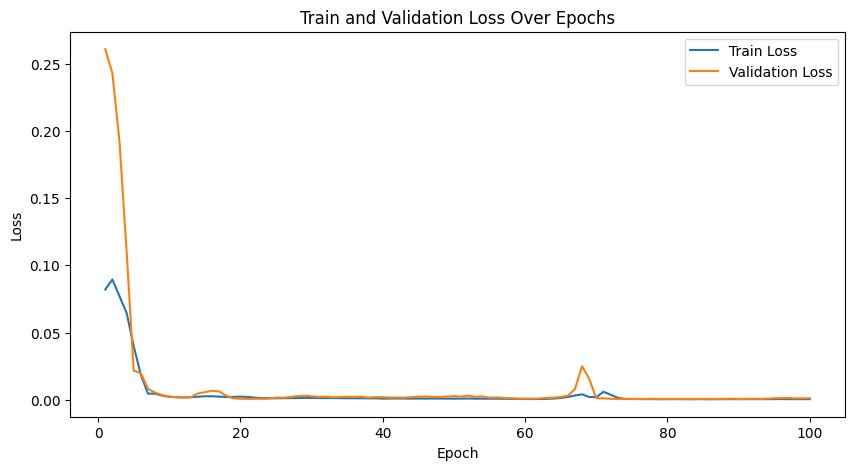

In [8]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

C:\Users\N98141062\AppData\Local\Temp\ipykernel_21732\3256922355.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('output/model/2330tw/mlp_lstm_5.pth')

MAE:  7.1273
RMSE: 9.3585
MAPE: 1.3403%
R²:   0.8731


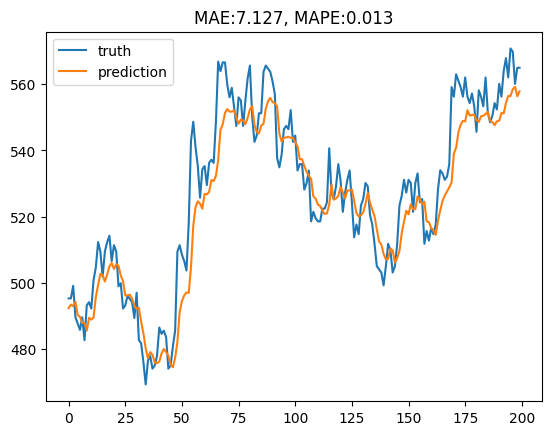

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
close_price_true = []
close_price_pred = []
model = torch.load('output/model/2330tw/mlp_lstm_5.pth')
model.to(device)

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device)).squeeze(-1)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['truth', 'prediction'])
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

In [10]:
btdf = pd.DataFrame({'close':df['Close'][-204:-4], 'rsi':df['rsi'][-204:-4],'predicted_close':close_price_pred})
btdf =btdf.dropna().reset_index(drop=True)
btdf

,close,rsi,predicted_close
0,498.186188,54.665447,492.387586
1,495.333923,52.878740,493.459505
2,496.284729,53.425225,492.982823
3,487.728088,48.027092,494.302382
4,490.580261,49.846199,490.256663
...,...,...,...
195,567.894043,65.586338,556.448525
196,567.894043,65.586338,558.479994
197,560.128052,55.190730,559.213229
198,564.981812,59.510359,556.384420


買入價格: 490.5802612304688
賣出價格: 484.8758850097656
cash: 988374.4812622069
額外要扣掉: 4315.995357691955
扣掉後的: 984058.4859045149
-------------------------------------
買入價格: 485.8266296386719
賣出價格: 489.4109802246094
cash: 991316.7958410383
額外要扣掉: 4301.884970248971
扣掉後的: 987014.9108707893
-------------------------------------
買入價格: 497.0580749511719
賣出價格: 492.2785949707031
cash: 977527.6431095588
額外要扣掉: 4265.764604086335
扣掉後的: 973261.8785054726
-------------------------------------
買入價格: 487.499267578125
賣出價格: 478.8963012695313
cash: 956090.3577535196
額外要扣掉: 4183.462473299343
扣掉後的: 951906.8952802202
-------------------------------------
買入價格: 476.0285949707031
賣出價格: 477.9403076171875
cash: 955728.4088605425
額外要扣掉: 4151.9729216914
扣掉後的: 951576.4359388511
-------------------------------------
買入價格: 474.1168823242188
賣出價格: 496.1021423339844
cash: 995700.8527784506
額外要扣掉: 4268.421415589832
扣掉後的: 991432.4313628607
-------------------------------------
買入價格: 542.6015625
賣出價格: 555.086181640625
cash: 10

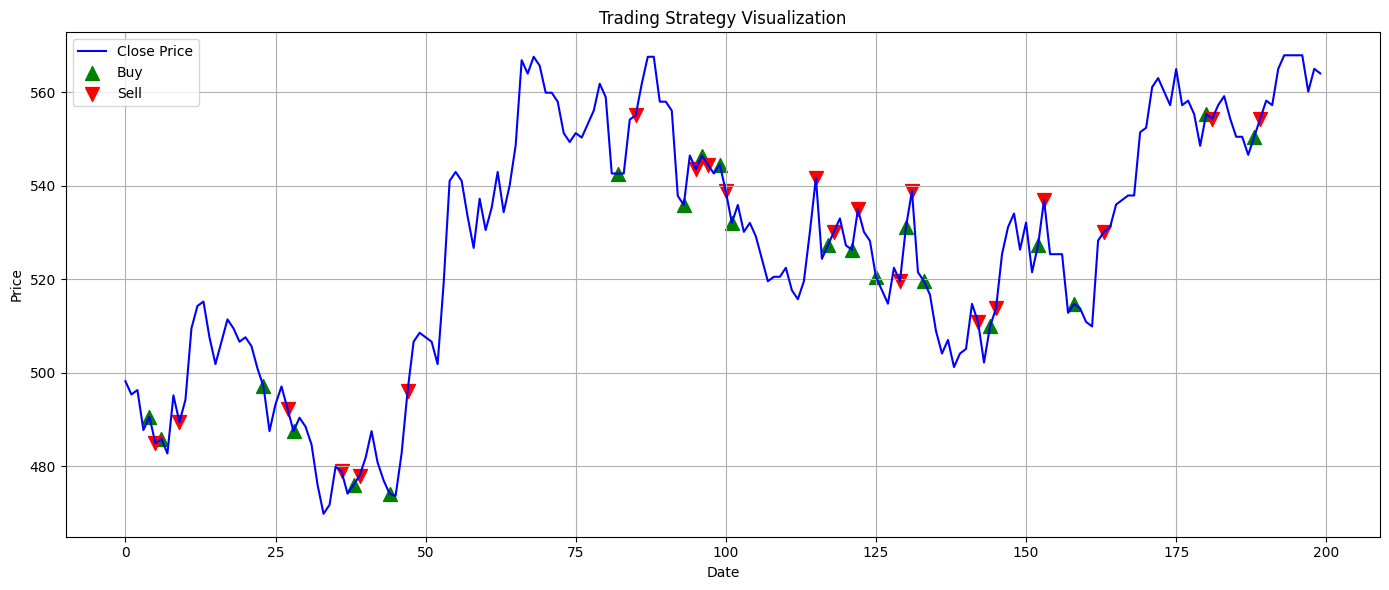

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 490.5802612304688
賣出價格: 542.9402465820312
cash: 1106709.6501464844
額外要扣掉: 4662.125726678467
扣掉後的: 1102047.524419806
-------------------------------------
買入價格: 542.6015625
賣出價格: 564.0111083984375
最終價格: 1145530.3121395325


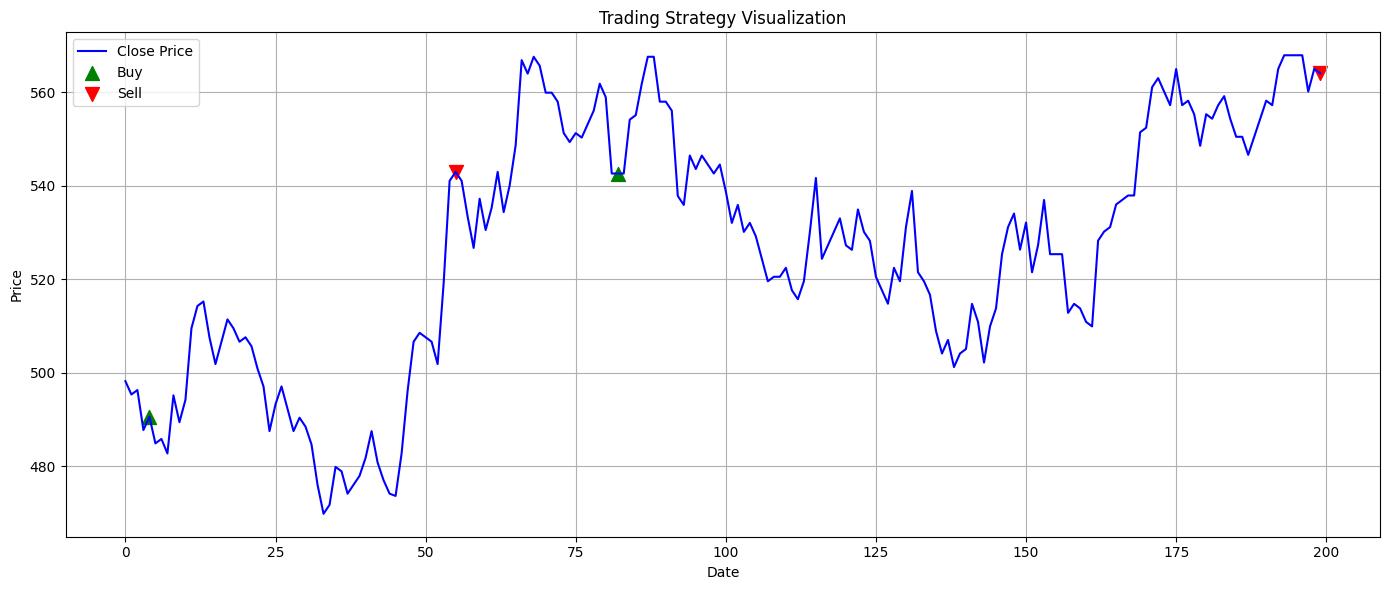

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 75.704 and btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
close_price_true = []
close_price_pred = []

dim = 3
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

(200, 5)
(200, 5)
MAE:  10.5819
RMSE: 13.3142
MAPE: 2.0110%
R²:   0.7468


In [14]:
import csv

with open('output/2330tw_output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(close_price_pred)):
    rows[i].append(close_price_pred[i][0].item())

# 寫回檔案
with open('output/2330tw_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)